# Primera parte: Introducción a las redes neuronales con Keras

En esta primera parte, vamos a utilizar una red neuronal para clasificar imágenes de prendas de ropa. Para ello, utilizaremos Keras con TensorFlow.

El dataset a utilizar es Fashion MNIST, un problema sencillo con imágenes pequeñas de ropa, pero más interesante que el dataset de MNIST. Puedes consultar más información sobre el dataset en [este enlace](https://github.com/zalandoresearch/fashion-mnist).

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados** (por ejemplo, a la hora de entrenar una red neuronal tiene que verse claramente un log de los resultados de cada epoch).

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

Primero, vamos a obtener los datos. Por suerte para nosotros, estos pueden ser descargados directamente desde Keras, por lo que no tendremos que preocuparnos de tratar con ficheros.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Acto seguido, normalizamos esos datos de manera similar a como hemos visto con MNIST, obteniendo valores entre 0 y 1. Este paso es muy importante para el correcto funcionamiento de nuestra red.

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## 1. Información sobre el dataset

Una vez tenemos los datos cargados en memoria, vamos a obtener información sobre los mismos.

**Pregunta 1.1 *(0.25 puntos)*** ¿Cuántas imágenes hay de *training* y de *test*? ¿Qué tamaño tienen las imágenes?

In [4]:
total_num_img = x_train.shape[0] + x_test.shape[0]
img_shape = x_train[0].shape
print(f"Total imágenes entrenamiento: {x_train.shape[0]}")
print(f"Total imágenes test: {x_test.shape[0]}")
print(f'Total de imágenes: {total_num_img}')
print(f'Tamaño de las imágenes: {img_shape}')

Total imágenes entrenamiento: 60000
Total imágenes test: 10000
Total de imágenes: 70000
Tamaño de las imágenes: (28, 28)


*Tu respuesta aquí*

**Pregunta 1.2 *(0.25 puntos)*** Realizar una exploración de las variables que contienen los datos. Describir en qué consiste un example del dataset (qué información se guarda en cada imagen) y describir qué contiene la información en y.

Cada imagen tiene 28 píxeles de altura y 28 píxeles de anchura, lo que supone un total de 784 píxeles. Cada píxel tiene un único valor de píxel asociado, que indica la luminosidad u oscuridad de ese píxel, siendo los números más altos los que significan mayor oscuridad. Este valor de píxel es un número entero entre 0 y 255 (despues de normalizarse entre 0 y 1), ya que son imágenes en escala de gris.

El vector $y$ corresponde a las etiquetas de las imágenes de ejemplo. En concreto, se tienen 10 clases códificadas en números del 0 al 9:
* 0 Camiseta/top
* 1 Pantalón
* 2 Jersey
* 3 Vestido
* 4 Abrigo
* 5 Sandalia
* 6 Camisa
* 7 Zapatilla de deporte
* 8 Bolso
* 9 Botín
En las gráficas de abajo se puede observar de forma visual la correspondencia de cada clase

A continuación, se va mostrar un gráfico de muestras aleatorias de cada clase y el número de ejemplo por clase. Esto se realizará tanto para el contjunto de entrenamiento como el test.

In [5]:
def plot_data_analysis(numero_columnas, numero_clases, img, y, titulo):

    numero_muestras = []
    #  Configuración de las dimensiones del gráfico
    figura, axis = plt.subplots(nrows=numero_clases, ncols=numero_columnas,
                                figsize=(6, 11))
    figura.tight_layout()

    #  Bucle aninado, que recorre las columnas y las clases
    for i in range(numero_columnas):
        for j in range(numero_clases):
            #  Se eliguen las imagenes que pertenecen a una clase
            x = img[y == j] 

            #  Se representa una imagen aleatoriamente.
            axis[j][i].imshow(x[random.randint(0, len(x - 1)),
                                :, :],
                            cmap=plt.get_cmap('gray'))

            # Desactivar cuadricula
            axis[j][i].axis("off")

            #  Titulo de la clase en la 2 columna y se guarda el número de muestras
            #  de cada clase.
            if i == 2:
                axis[j][i].set_title(str(j))
                numero_muestras.append(sum(y == j))

    #  Configuración de las dimensiones del gráfico
    plt.figure(figsize=(10, 6))
    plt.bar(range(0, numero_clases), numero_muestras, width=0.7, color="blue")

    #  Creación de las barras del grafico, con el número de muestras por clase
    for i in range(0, numero_clases):
        plt.text(i, numero_muestras[i], str(numero_muestras[i]),
                horizontalalignment='center', fontsize=14)

    #  Configuración de la apariencia del gráfico.
    plt.tick_params(labelsize=14)
    plt.xticks(range(0, numero_clases))
    plt.xlabel("Clases", fontsize=16)
    plt.ylabel("Nº de muestras", fontsize=16)
    plt.title(f"Frecuencia del conjunto {titulo}", fontsize=20)
    plt.show()

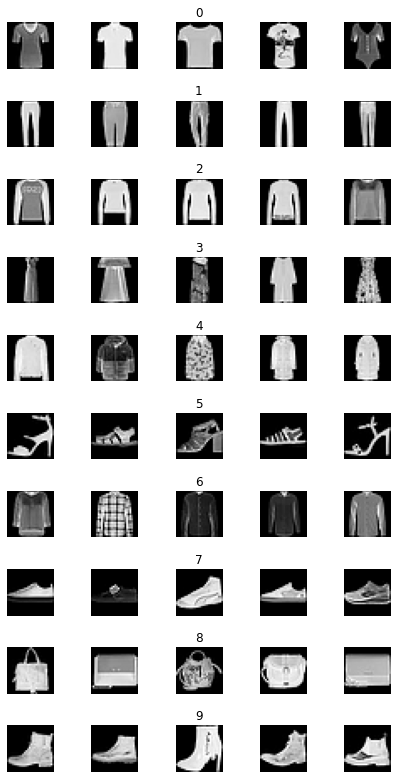

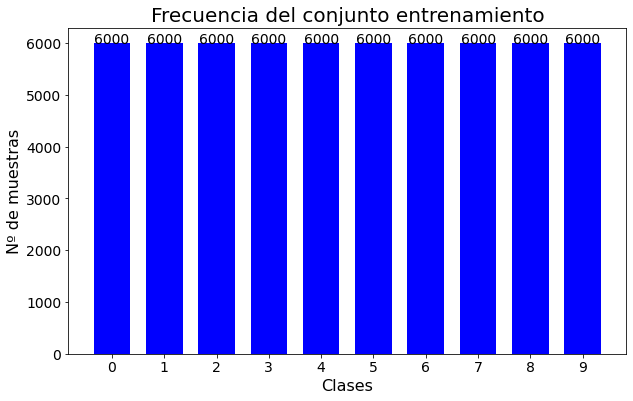

In [6]:
plot_data_analysis(5, 10, x_train, y_train, 'entrenamiento')

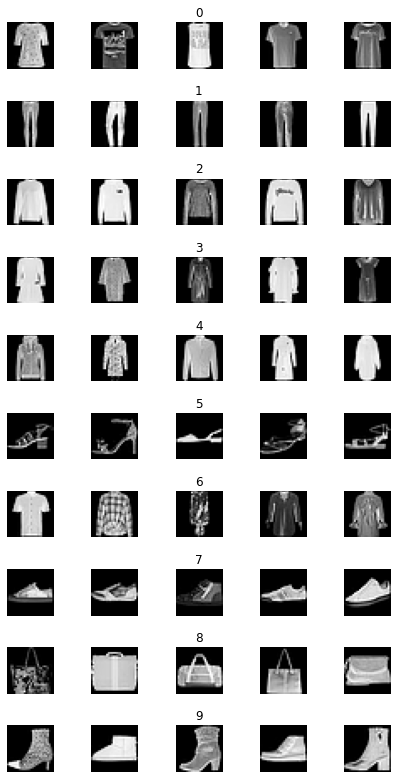

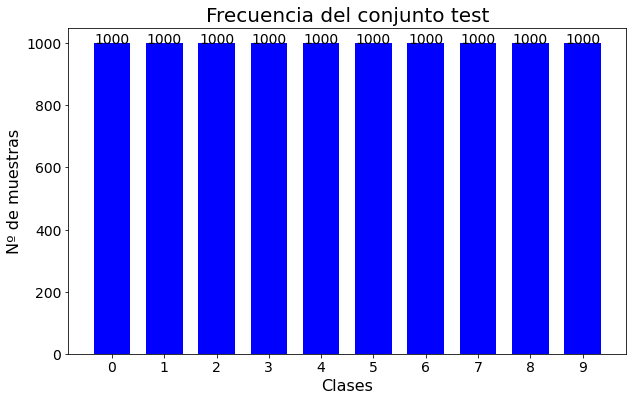

In [7]:
plot_data_analysis(5, 10, x_test, y_test, 'test')

Vamos a **visualizar** una imagen de ejemplo. Prueba tu mismo a cambiar la imagen en uso para explorar el dataset visualmente ejecutando el siguiente código:

In [8]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

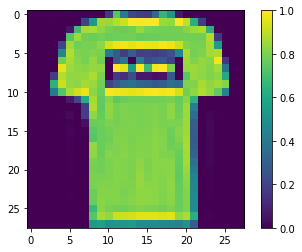

In [9]:
visualize_example(x_train[1])

## 2. Entrenamiento de una red neuronal simple

**Pregunta 2 *(3.5 puntos)***. Utilizando Keras, y preparando los datos de X e y como fuera necesario, define y entrena una red neuronal que sea capaz de clasificar imágenes de Fashion MNIST con las siguientes características:

* Dos hidden layers de tamaños 128 y 64, utilizando unidades **sigmoid**
* Optimizador **sgd**.
* Durante el entrenamiento, la red tiene que mostrar resultados de **loss** y **accuracy** por cada epoch.
* La red debe entrenar durante **20 epochs** y batch size de **64**.
* La última capa debe de ser una capa **softmax**.

Tu red tendría que ser capaz de superar fácilmente 60% de accuracy.

In [10]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(64, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history = model.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
)

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 2.3002 - accuracy: 0.2798
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9470 - accuracy: 0.5566
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5497 - accuracy: 0.5986
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 1.2817 - accuracy: 0.6348
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 1.1116 - accuracy: 0.6681
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.9843 - accuracy: 0.6974
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.9008 - accuracy: 0.7172
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.8339 - accuracy: 0.7284
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.7790 - accuracy: 0.7388
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.7369 - accuracy: 0.7461

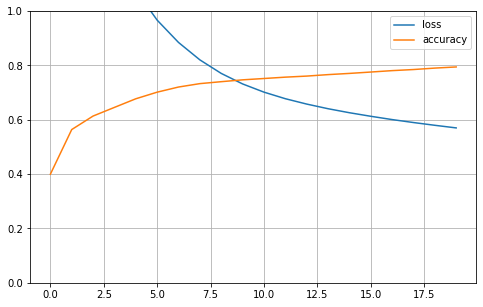

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## 3. Evaluación del modelo en datos de test

Una vez hemos entrenado nuestro modelo, vamos a evaluarlo en los datos de test de Fashion MNIST.

**Pregunta 3.1 *(0.5 puntos)***. Utilizando el modelo recién entrenado, obtener la accuracy resultante en el dataset de test.

In [13]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.5862 - accuracy: 0.7849


[0.5861960053443909, 0.7849000096321106]

**Pregunta 3.2 *(0.5 puntos)***. Utilizando el método **predict** de Keras, realizar predicciones para los datos de test. Por cada predicción resultante, ¿qué significan los números que obtenemos al hacer predict? ¿Cómo podemos obtener el valor de la clase resultante? (recordar que estamos utilizando una capa softmax para clasificar).

Como la última capa tiene una función de activación $softmax$, la salida de la red corresponderá con un vector con la probabilidad de cada clase (la suma de todas las probabilidades será 1). La clase con una mayor probalidad será la clase predicha por la red.

Probabilidad de la clase 0 es 0.00
Probabilidad de la clase 1 es 0.99
Probabilidad de la clase 2 es 0.00
Probabilidad de la clase 3 es 0.01
Probabilidad de la clase 4 es 0.00
Probabilidad de la clase 5 es 0.00
Probabilidad de la clase 6 es 0.00
Probabilidad de la clase 7 es 0.00
Probabilidad de la clase 8 es 0.00
Probabilidad de la clase 9 es 0.00
La suma de las probabilidades de todas las clases es 1



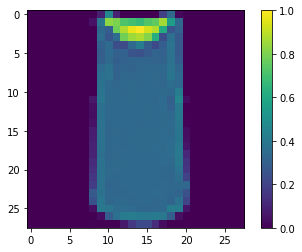

Predicción: 1
Clase real: 1
La red ha acertado la predicción.


In [46]:
sample_index = 2

# Lista con la probabilidad de cada clase
array_pred = model.predict(x_test)[sample_index]

# Clase predicha
predicted = np.argmax(array_pred)

# Clase real
label = y_test[sample_index]

# Mostrar prob de cada clase
for clase_pred, i in zip(array_pred, range(0, 10)):
    print(f"Probabilidad de la clase {i} es {clase_pred:.2f}")
print(f"La suma de las probabilidades de todas las clases es {round(sum(array_pred))}\n")

# Resultado final
visualize_example(x_train[sample_index])
print(f"Clase predicha: {predicted}\nClase real: {label}")
print(f"La red {'' if predicted == label else 'no '}ha acertado la predicción.")